In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

%run utility_functions.py # functions reused throughout

-1    4849
 1    1001
Name: cleave, dtype: int64

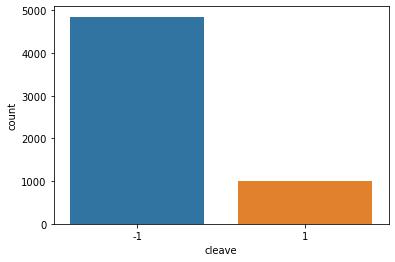

In [3]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)
# skewed toward predicting negative because more examples?

In [5]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale it
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [6]:
# reusing 'best' parameters from GridSearch for DT without boosting
# passing max_depth into the gridsearch
# smaller max_depth for boost. Tried 1 and 4, 1 was better by 2 %
dt = DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=1, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0,
                       random_state=0, splitter='best')

parameters = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 100, 200, 300, 400, 500],
              "learning_rate": [.01, .05, 1.0, 1.5, 2.0],
             }

# scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

bdt = AdaBoostClassifier(dt, random_state=0)

grid_obj = GridSearchCV(bdt,parameters, scoring=acc_scorer, cv=10, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_

clf.get_params()


{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.001,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': 'log2',
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 0,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.001, max_depth=1, max_features='log2',
                        min_samples_split=5, random_state=0),
 'learning_rate': 1.5,
 'n_estimators': 400,
 'random_state': 0}

In [8]:
# train model
clf.fit(x_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.001,
                                                         max_depth=1,
                                                         max_features='log2',
                                                         min_samples_split=5,
                                                         random_state=0),
                   learning_rate=1.5, n_estimators=400, random_state=0)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.972


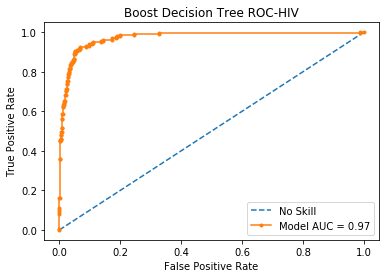

Model: f1=0.819 auc=0.900


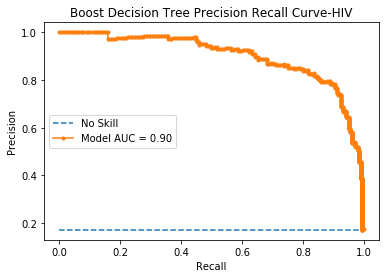

Classification Report
              precision    recall  f1-score   support

          -1       0.96      0.97      0.96       969
           1       0.84      0.80      0.82       201

    accuracy                           0.94      1170
   macro avg       0.90      0.88      0.89      1170
weighted avg       0.94      0.94      0.94      1170

Confusion Matrix
[[938  31]
 [ 40 161]]


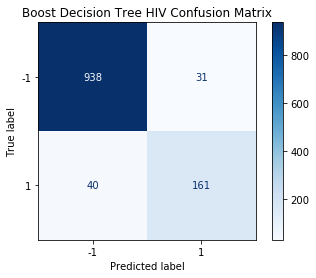

<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

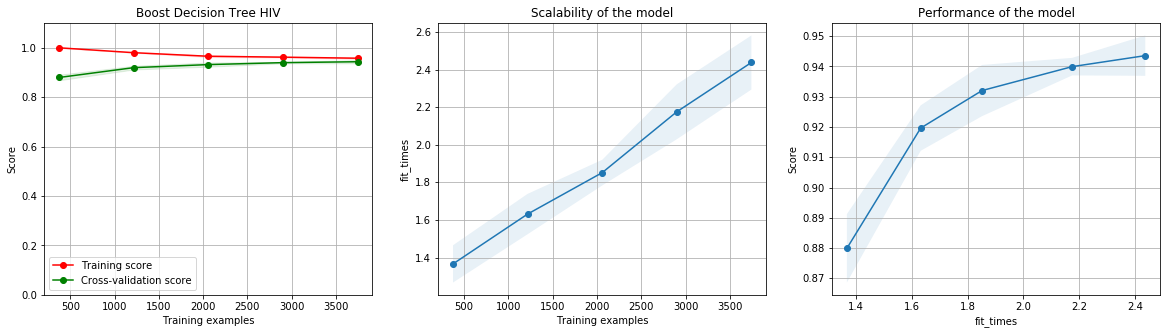

In [9]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'Boost Decision Tree ROC-HIV')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'Boost Decision Tree Precision Recall Curve-HIV')

# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels=['-1', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
cm.ax_.set_title('Boost Decision Tree HIV Confusion Matrix')
plt.savefig('../images/cm_Boost_DT_HIV.png')
plt.show()

#print('Accuracy')
#print(accuracy_score(y_test, y_predict))

# for unbalanced data
#print('Balanced Accuracy')
#print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Boost Decision Tree HIV", x_train, y_train, ylim=[0,1.1])

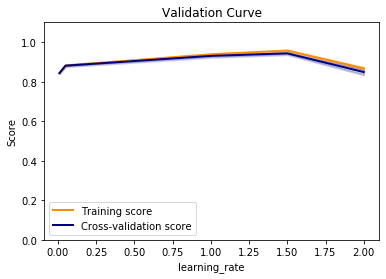

In [10]:
plot_model_complexity_analysis(clf, "learning_rate", [.01, .05, 1.0, 1.5, 2.0], 'Boost_HIV', x_train, y_train)

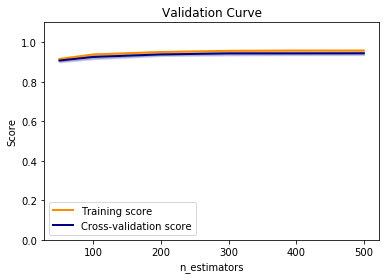

In [11]:
plot_model_complexity_analysis(clf, "n_estimators", [50, 100, 200, 300, 400, 500], 'Boost_HIV', x_train, y_train)

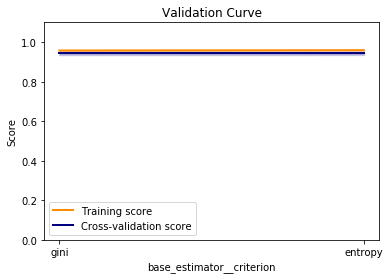

In [12]:
plot_model_complexity_analysis(clf, "base_estimator__criterion", ["gini", "entropy"], 'Boost_HIV', x_train, y_train)

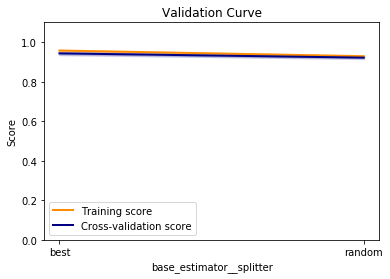

In [13]:
plot_model_complexity_analysis(clf, "base_estimator__splitter", ["best", "random"], 'Boost_HIV', x_train, y_train)